# **Supervised Transformer Training for Melanoma Detection**

The aim of this notebook is to offer an analysis of how a Transformer model performs on Melanoma image classification.

### **Author:** Leandro Jorge Fernández Vega

---

## **Additional Information**

The documentation of the functions and comment formatting has been done with the integrated version of Google Gemini.

## **Libraries**

In [ ]:
# Install and upgrade fastai and related libraries
!pip install -U "fastai==2.7.15" "fastcore==1.5.29" "fastprogress==1.0.3" "fastdownload==0.0.7"

# Import necessary libraries
import os
from google.colab import files, drive
from google.colab import drive
from fastai.vision.all import *
import fastcore
from pathlib import Path
import timm
import time
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
!pip install dill
import dill

## **Auxiliar Functions**

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    """
    Plots the training and validation metrics recorded during the learning process.

    This function extends the fastai `Recorder` class to visualize various metrics
    (e.g., losses, accuracy, F1-score) over epochs.
    Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

    Args:
        self (Recorder): The Recorder object containing the metric history.
        nrows (int, optional): Number of rows for the subplot grid. Defaults to None.
        ncols (int, optional): Number of columns for the subplot grid. Defaults to None.
        figsize (tuple, optional): Figure size (width, height) in inches. Defaults to None.
        **kwargs: Additional keyword arguments passed to `fastai.plt.subplots`.

    Returns:
        None: Displays the plot directly.
    """
    # Stack the recorded metric values into a NumPy array
    metrics = np.stack(self.values)
    # Get the names of the metrics (excluding 'epoch' and 'time')
    names = self.metric_names[1:-1]
    n = len(names) - 1 # Number of metrics to plot (excluding 'time' and 'epoch', and 'valid_loss' for the first plot)

    # Determine the number of rows and columns for the subplot grid
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))

    # Set the figure size, default if not provided
    figsize = figsize or (ncols * 6, nrows * 4)
    # Create the subplot grid
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    # Flatten the axes array and set unused axes to off if n < total subplots
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

    # Iterate through each metric and plot it
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)): # [axs[0]] + axs ensures loss is plotted on the first ax
        # Plot training and validation metrics. First plot shows train loss (blue), others show valid loss (orange).
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        # Set the title for each subplot
        ax.set_title(name if i > 1 else 'losses') # Title 'losses' for the first plot, otherwise the metric name
        # Display legend
        ax.legend(loc='best')
    plt.show() # Display the plot

In [ ]:
def melanoma_auc_recall(learn, dl, class_name='melanoma'):
    """
    Calculates and plots AUC and Recall for a specific class using fastai tensors.

    This function retrieves predictions and true labels from a fastai Learner object
    for a given DataLoader and then computes the Area Under the Receiver Operating
    Characteristic Curve (AUC) and Recall for a specified class. It also generates
    and displays an ROC curve plot.

    Args:
        learn (fastai.learner.Learner): The trained fastai Learner object.
        dl (fastai.data.core.DataLoader): The DataLoader (e.g., dls.valid, dls.train)
                                          from which to get predictions and targets.
        class_name (str, optional): The name of the class for which to calculate
                                    AUC and Recall. Defaults to 'melanoma'.

    Returns:
        tuple: A tuple containing the calculated AUC and Recall scores for the
               specified class. Returns (None, None) if the class name is not found.
    """
    if class_name not in learn.dls.vocab:
        print(f"⚠️ Warning: The class '{class_name}' does not exist in the vocabulary.")
        return None, None

    # 1. Get the index of the specified class and model predictions
    idx = learn.dls.vocab.o2i[class_name]
    preds, targs = learn.get_preds(dl=dl)

    # 2. Filter predictions and targets for the specified class (Fastai style tensors)
    y_score = preds[:, idx]       # Probabilities for the positive class
    y_true  = (targs == idx)      # Binary target (True/False) indicating presence of the class

    # 3. Calculate metrics using sklearn (handles implicitly converted PyTorch tensors)
    auc = roc_auc_score(y_true, y_score)
    rec = recall_score(y_true, preds.argmax(dim=1) == idx)

    print(f"\n📊 Metrics for '{class_name}':")
    print(f"   • ROC-AUC: {auc:.4f}")
    print(f"   • Recall:  {rec:.4f}")

    # 4. Plot the Receiver Operating Characteristic (ROC) Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0,1], [0,1], 'k--') # Diagonal dashed line for reference
    plt.title(f"ROC: {class_name} vs Rest")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

    return auc, rec

In [ ]:
def show_results(dls, learner, mode, melanoma_class='melanoma'):
    """
    Displays the Confusion Matrix and calls the `melanoma_auc_recall` function
    for a specified mode (Train, Validation, or Test).

    Args:
        dls (fastai.data.core.DataLoaders): The fastai DataLoaders object containing
                                             training, validation, and optionally test DataLoaders.
        learner (fastai.learner.Learner): The trained fastai Learner object.
        mode (str): The mode for which to show results. Must be 'Train', 'Validation', or 'Test'.
        melanoma_class (str, optional): The name of the class to focus on for AUC and Recall.
                                        Defaults to 'melanoma'.

    Raises:
        ValueError: If an unsupported mode is provided.
    """
    print(f"\n{'='*20} Evaluating: {mode} {'='*20}")

    # 1. DataLoader Selector
    if mode == 'Validation': dl = dls.valid
    elif mode == 'Train':    dl = dls.train
    elif mode == 'Test':
      # For the 'Test' mode, create a test DataLoader from image files
      test_files = [fn for fn in sorted(test_path.glob('**/*')) if fn.is_file()]
      dl = learner.dls.test_dl(test_files,with_labels=True, device='cuda') # Test set also normalized the same way
    else: raise ValueError("Mode must be 'Train', 'Validation' or 'Test'")

    # 2. Confusion Matrix and Global Accuracy
    interp = ClassificationInterpretation.from_learner(learner, dl=dl)
    interp.plot_confusion_matrix(figsize=(6, 6), title=f'Confusion Matrix ({mode})')
    plt.show()

    cm = interp.confusion_matrix()
    acc = np.trace(cm) / np.sum(cm) * 100
    print(f"✅ Global Accuracy: {acc:.2f}%")

    # 3. Call to the separate metrics function
    melanoma_auc_recall(learner, dl, class_name=melanoma_class)

## **Dataset Preparing**

### **Download**

To download the file and ensure no time is wasted, we decided to use Google Gemini to build a pipeline for downloading the dataset:

**You are an expert in Kaggle, datasets, deep learning and python. I need a pipeline to be able to download a dataset from Kaggle. You need to include flags to avoid downloading the dataset every time the cell is executed, as well as oher security flags. Manage resources in a way the access to the dataset is fast.**

---

<br>

After a few minor changes, we obtained an excellent pipeline to obtain the dataset without the need to download every time the cell is executed. This is only necessary when the environment is changed.

The authentication with Kaggle is carried out through the upload of a JSON file generated from the person's personal account. Once the file is uploaded, the zip containing the dataset will be downloaded, then unzipped and deleted.

Everything is managed in dymanic memory, so it is necessary to activate **High RAM Capacity** when selecting the environment.

In [ ]:
# --- 1. KAGGLE API CONFIGURATION ---
kaggle_json_path = os.path.expanduser("~/.config/kaggle/kaggle.json")
token_setup_successful = False

# Check if kaggle.json already exists
if not os.path.exists(kaggle_json_path):
    print("⬇️ Token not found. Upload your kaggle.json file ⬇️")
    uploaded = files.upload() # files.upload() returns a dict of uploaded files

    if 'kaggle.json' in uploaded:
        # Create the hidden folder if it doesn't exist
        !mkdir -p ~/.config/kaggle
        # Move the json file into it
        !mv kaggle.json ~/.config/kaggle/ # Use mv to avoid leaving a copy in /content
        # Set secure permissions (read/write only for user)
        !chmod 600 ~/.config/kaggle/kaggle.json
        print("✅ Configuration complete: File moved to ~/.config/kaggle/")
        token_setup_successful = True

        # Install kaggle library and check its version
        !pip install kaggle --quiet
        !kaggle --version
        from kaggle.api.kaggle_api_extended import KaggleApi
    else:
        print("❌ kaggle.json file not uploaded. Make sure to upload it to continue.")
else:
    print("✅ kaggle.json already exists in ~/.config/kaggle/. Skipping upload.")
    token_setup_successful = True

# Proceed with authentication and download only if the token was set up correctly
if token_setup_successful:
    try:
        # Initialize the API (this must always be done to ensure the API is authenticated)
        # The API will automatically look for the kaggle.json file in ~/.config/kaggle/
        api = KaggleApi()
        api.authenticate()
        print("✅ Kaggle API authentication successful.")

        # --- 2. DATASET DOWNLOAD ---
        dataset_path = '/content/dataset'

        # Check if the dataset is already downloaded and unzipped
        # Check if the folder exists and if it contains files
        if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
            print("⏳ Downloading dataset to /content/dataset...")
            api.dataset_download_files(
                'wanderdust/skin-lesion-analysis-toward-melanoma-detection',
                path=dataset_path,
                unzip=True,
                quiet=False
            )
            print("✅ Download complete!")

            # Delete the downloaded zip file to save space
            print("🧹 Cleaning up zip files...")
            for file in os.listdir(dataset_path):
                if file.endswith(".zip"):
                    os.remove(os.path.join(dataset_path, file))
            print("✅ Zip file deleted successfully.")
        else:
            print("✅ Dataset already downloaded and unzipped in /content/dataset/. Skipping download.")
    except Exception as e:
        print(f"❌ Error during authentication or dataset download: {e}")
else:
    print("⚠️ Cannot proceed with authentication or dataset download without a valid kaggle.json file.")

✅ kaggle.json already exists in ~/.config/kaggle/. Skipping upload.
✅ Kaggle API authentication successful.
✅ Dataset already downloaded and unzipped in /content/dataset/. Skipping download.


### **Creation of the Datablock**

In [ ]:
# List files and directories in the current working directory
!ls -lha
# List files and directories within the downloaded dataset path
!ls /content/dataset/skin-lesions/

total 24K
drwxr-xr-x 1 root root 4.0K Dec 28 11:47 .
drwxr-xr-x 1 root root 4.0K Dec 28 11:23 ..
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 3 root root 4.0K Dec 28 11:47 dataset
drwxr-xr-x 2 root root 4.0K Dec 28 11:48 models
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
test  train  valid


In [ ]:
# Define the base path for the dataset
path = Path("/content/dataset/skin-lesions")
# Define paths for training, validation, and test sets
train_path = path/'train'
valid_path = path/'valid'
test_path  = path/'test'

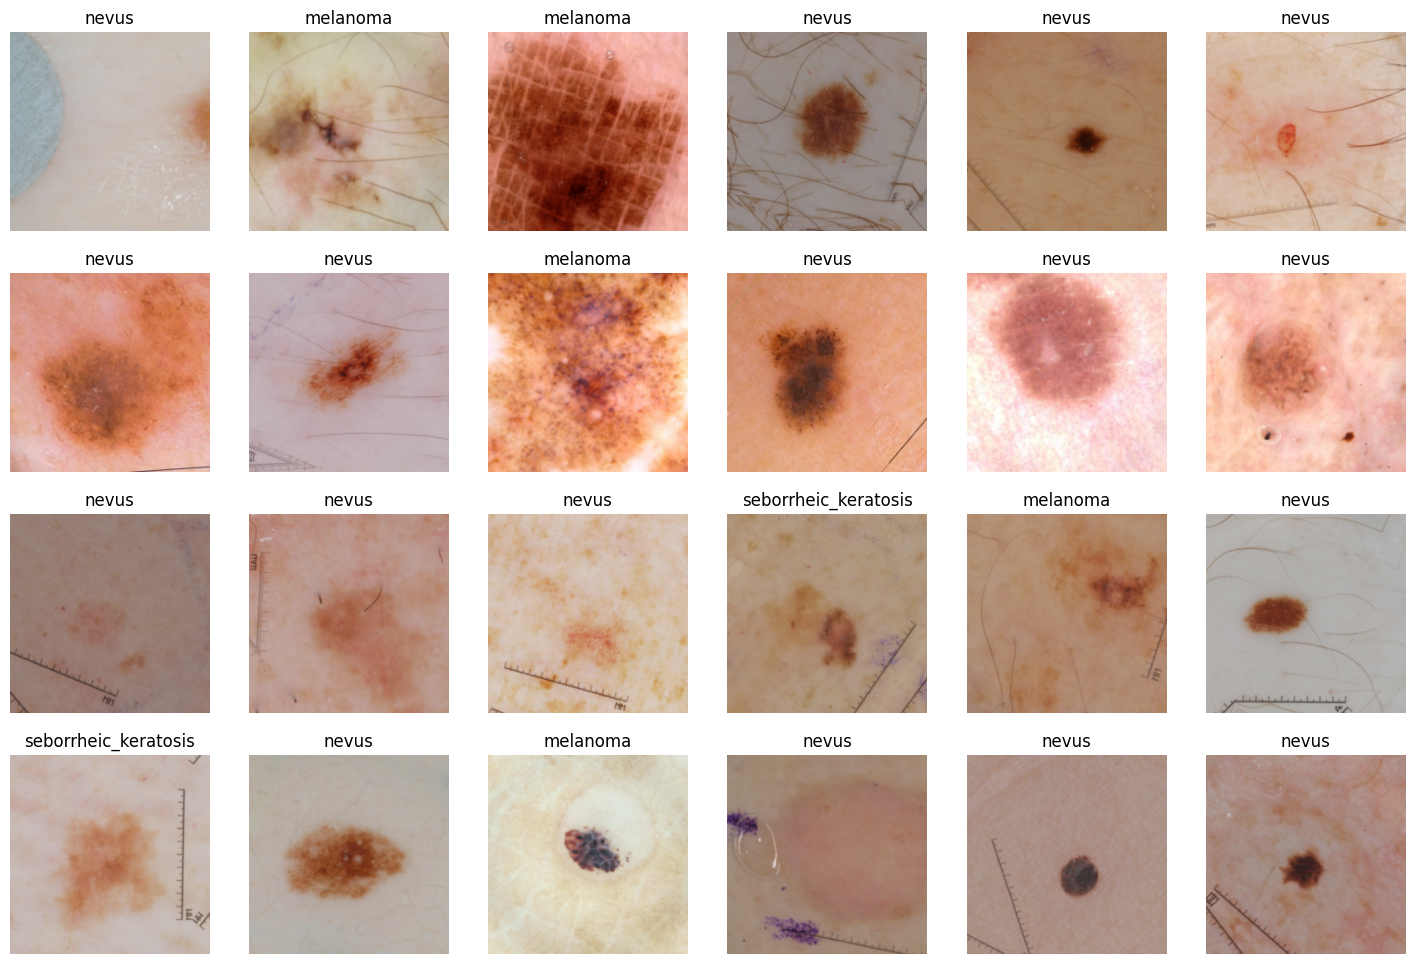

In [ ]:
# Create a DataBlock for image classification
dtblk = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define input (Image) and target (Category) blocks
    get_items=get_image_files,         # Function to get all image files
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), # Split data based on 'train' and 'valid' folders
    get_y=parent_label,                # Function to get labels from parent folder names
    item_tfms=Resize(224),             # Apply resizing to 224x224 for individual items
    batch_tfms=[                       # Apply batch transformations (augmentation and normalization)
        *aug_transforms(do_flip=True, max_rotate=90, max_zoom=1.2, max_lighting=0.2, max_warp=0),
        Normalize.from_stats(*imagenet_stats) # Normalize using ImageNet statistics
    ]
)

# Create DataLoaders from the DataBlock and the specified path, with a batch size of 32
dls=dtblk.dataloaders(path,bs=32)

# Display a batch of images with their labels
dls.show_batch(max_n=24)

## **Transformer Model**

<br>

### **1) What is a Transformer?**

#### **1.1) Explanation**

A Transformer is an architecture based on self-attention: each element of a sequence (token) can “look at” the other tokens and combine information from them.

Instead of processing the sequence step by step (like RNNs), the Transformer processes many tokens in parallel.

The key operation is Scaled Dot-Product Attention, which takes as input:

- $Q$ (queries)
- $K$ (keys) of dimension $d_k$
- $V$ (values) of dimension $d_v$, obtained by applying linear projections to the input embeddings.

In practice, the attention function is computed over a set of queries at once, stacked into a matrix $Q$. Keys and values are also stacked into matrices $K$ and $V$. The output matrix is computed as follows:

\begin{equation}
Attention(Q,K,V)=softmax\Big(\frac{QK^{T}}{\sqrt{d_k}}\Big)V
\end{equation}

##### **Intuition behind the equation:**

  - $QK^T$ computes “similarities” between tokens (which token should attend to which).
  - $\sqrt{d_k}$ stabilizes the softmax (prevents dot products from growing too large).
  - $softmax(\cdot)$ converts similarities into weights (they sum to $1$).
  - The output is a weighted combination of the values $V$.

<br>

#### **1.2) Multi-Head Attention (MHA)**

- The Transformer uses Multi-Head Attention (MHA). Instead of performing a single attention function, it is more beneficial to linearly project the queries, keys, and values $h$ times with different learned linear projections, to dimensions $d_k$, $d_k$, and $d_v$ respectively.
- Multiple attentions (“heads”) are computed in parallel.
- Each head can specialize in different relationships (for example, local vs global dependencies).
- The outputs are then concatenated and projected again.

<br>

##### **Example: In the sentence *The cat that was on the roof jumped***
  - One head may relate “cat” with “jumped”.
  - Another may relate “that” with “was”.
  - Another may focus on “roof” as context.
- With a single head, all these relations are mixed together, making them harder to capture clearly.

<br>

#### **1.3) Why are positional embeddings needed?**

- Attention by itself does not “know” which token comes before or after: order is not implicit.
- Therefore, positional information is added to each token.
- A classical (sinusoidal) version defines a positional vector $p_t \in \mathbb{R}^{d_{model}}$ using sines and cosines at different frequencies:

\begin{equation}
\vec{p}_t(i)=
\begin{cases}
\sin(\omega_k\, t) & \text{if } i = 2k,\\
\cos(\omega_k\, t) & \text{if } i = 2k+1,
\end{cases}
\end{equation}

where

\begin{equation}
\omega_k = \frac{1}{10000^{\frac{2k}{d}}}.
\end{equation}

Finally, the positional embedding is added to the token embedding:
\begin{equation}
\psi'(w_t) = \psi(w_t) + \vec{p}_t.
\end{equation}

<br>

### **Architecture**

The model consists of an encoder and a decoder, both composed of a stack of $N=6$ identical layers. All sub-layers, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$.


On the other hand, each sub-layer is employed with a residual connection followed by layer normalization. The output of each sub-layer is:

  $$LayerNorm(x + Sublayer(x))$$

#### **1. Encoder Stack**

- Composition: The encoder is composed of a stack of $N=6$ identical layers.
- Sub-layers: Each layer has two sub-layers:
  1. Multi-Head Self-Attention: Allows the encoder to attend to all positions in the previous layer.
  2. Position-wise Feed-Forward Network: A simple, fully connected network applied to each position.

#### 2. **Decoder Stack**

- Composition: The decoder is also composed of a stack of $N=6$ identical layers.
- Sub-layers: In addition to the two sub-layers found in the encoder, the decoder inserts a third sub-layer:
  1. Masked Multi-Head Attention: Modified to prevent positions from attending to subsequent positions. This masking ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.
  2. Encoder-Decoder Attention: Performs multi-head attention over the output of the encoder stack (Keys and Values come from the encoder, Queries come from the previous decoder layer).
  3. Position-wise Feed-Forward Network.


<br>

### **2) How is it adapted to vision? Vision Transformer (ViT)**

<br>

#### **2.1. From image to sequence: patches as “tokens”**

- ViT transforms an image into a sequence of visual tokens.
- The image is divided into patches of size $P \times P$.
- If the image has size $H \times W$, the number of patches is:

\begin{equation}
N = \frac{H W}{P^2}
\end{equation}

- In the chosen model `vit_tiny_patch16_224`:
  - $H = W = 224$, $P = 16$ $\Rightarrow N = (224/16)^2 = 14^2 = 196$ patches.
- Each patch is flattened and linearly projected to dimension $d_{model}$ (embedding).
- In addition, a special CLS token (classification token) is added to obtain a global image representation.

<br>

#### **2.2. Transformer encoder over visual tokens**

- After converting each patch into an embedding of dimension $d_{model}$, you obtain a sequence:
  - $196$ patch embeddings, plus the embedding of the [CLS] token.
- This forms an embedding matrix of size $(N+1) \times d_{model}$.
- The Transformer uses constant latent vectors (representations of the data in a lower-dimensional space) of size $d_{model}$, so after flattening the patches they are mapped to $d_{model}$ dimensions with a trainable linear projection.
- ViT adds a learnable positional embedding $E_{pos}$ with the same shape $(N+1) \times d_{model}$.
- Key operation: element-wise sum:

\begin{equation}
Z_0 = \big[\,x_{cls};\; x_{p}^{1}E;\;\dots;\;x_{p}^{N}E\,\big] + E_{pos}
\end{equation}

- Intuition:
  - $\big[\,x_{\mathrm{cls}};\; x_{p}^{1}E;\dots\big]$ are the embeddings; each $x_{p}^{i}$ is the $i$-th image patch of size $P^2C$ (with $C$ channels), and $E$ is the linear projection matrix that maps each patch to the model dimension $d_{model}$.
  - $E_{pos}$ injects information about where each patch is located in the image.
  - Since the sum does not change dimensionality, the Transformer can consume the sequence just like in natural language processing (NLP).

<br>

##### **2.2.1 The sequence passes through $L$ Transformer encoder blocks**

- A Transformer encoder is a stack of $L$ identical blocks.
- Each block has two main sublayers:
  - MHA: Multi-Head Self-Attention.
  - MLP: Multi-Layer Perceptron.

- In ViT, a pre-norm scheme is typically used:
  - LayerNorm (LN) is applied before each sub-block,
  - Residual connections (skip connections) are used after each sub-block.

If we denote $Z_{\ell-1}$ as the token sequence (matrix $(N+1)\times d_{model}$) at the input of block $\ell$:

1) Attention sub-block (MHA):
\begin{equation}
\hat{Z}_\ell = Z_{\ell-1} + MHA(LN(Z_{\ell-1}))
\end{equation}

2) MLP sub-block (token-wise feed-forward):
\begin{equation}
Z_\ell = \hat{Z}_\ell + MLP(LN(\hat{Z}_\ell))
\end{equation}

- Intuition:
  - MHA mixes information across patches: a patch can attend to other relevant patches.
  - MLP processes each token independently in a nonlinear way to refine the representation.
  - Residuals help stabilize training and improve gradient flow.

<br>

### **Main references**

- Transformer: Vaswani et al., *Attention Is All You Need*, 2017.
- ViT: Dosovitskiy et al., *An Image is Worth 16×16 Words*, 2020/2021.


## **Pipeline**

- The first approach was to introduce data augmentation, consider Adam Optimizer with momentum and use Cross Entropy Loss as loss function. Leslie's One Cycle Policy seemed a good option for training, as well as using a dymanic learning rate finder. However, the model converged faster than expected and was overfitted.

- To regularize the model and speed training, data augmentation was increased, the number of epochs reduced and the loss function changed to Cross Entropy Loss with label smoothing. Besides, internal regularization and weight decay where introduced.

- After some tuning, the best combination of hyperparameters turned out to be the following:

In [ ]:
# Create a Vision Transformer model using timm library
transformer_model = timm.create_model(
    "vit_tiny_patch16_224",   # Model architecture: tiny ViT with 16x16 patches and 224x224 input size
    pretrained=True,          # Use pre-trained weights (from ImageNet)
    num_classes=dls.c,         # Number of output classes, determined from the DataLoaders
    drop_path_rate=0.2         # Stochastic depth rate for regularization
)

# Create a fastai Learner object
learn = Learner(
    dls,
    transformer_model,
    loss_func=LabelSmoothingCrossEntropyFlat(), # Loss function: LabelSmoothingCrossEntropy for better generalization
    metrics=[accuracy, F1Score(average='macro')], # Evaluation metrics: accuracy and F1-score (macro-averaged)
    opt_func=partial(Adam, mom=0.9) # Optimizer: Adam with momentum set to 0.9

).to_fp16() # Use mixed precision (half-precision floats) for faster training and reduced memory usage

# Display a summary of the model architecture and trainable parameters
learn.summary()

VisionTransformer (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 192 x 14 x 14  
Conv2d                                    147648     True      
Identity                                                       
Dropout                                                        
Identity                                                       
Identity                                                       
LayerNorm                                 384        True      
____________________________________________________________________________
                     32 x 197 x 576      
Linear                                    111168     True      
Identity                                                       
Identity                                                       
Identity                                                       
Linear                                    37056      True      
Dropout            

## **Training**

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.083585,1.119626,0.513333,0.383593,00:55
1,0.945965,0.872809,0.600000,0.486018,00:53
2,0.854081,0.766445,0.733333,0.659524,00:56
3,0.798019,0.809614,0.680000,0.561563,00:55
4,0.761294,0.696189,0.773333,0.712448,00:52
5,0.723006,0.666600,0.800000,0.735457,00:54
6,0.702974,0.652610,0.813333,0.778428,00:56
7,0.675774,0.654858,0.793333,0.734914,00:54
8,0.662973,0.634179,0.833333,0.797258,00:54
9,0.663980,0.640754,0.806667,0.763889,00:56


Total training time: 551.20 seconds


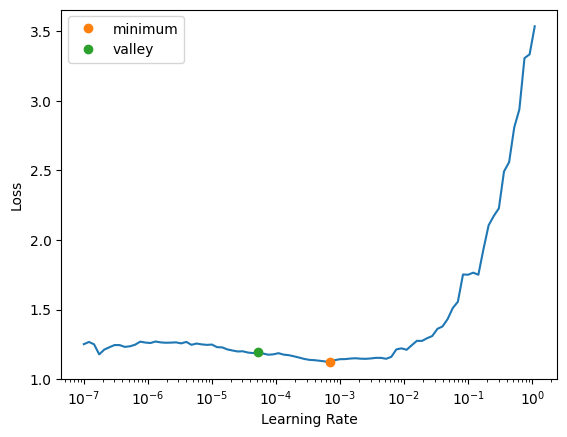

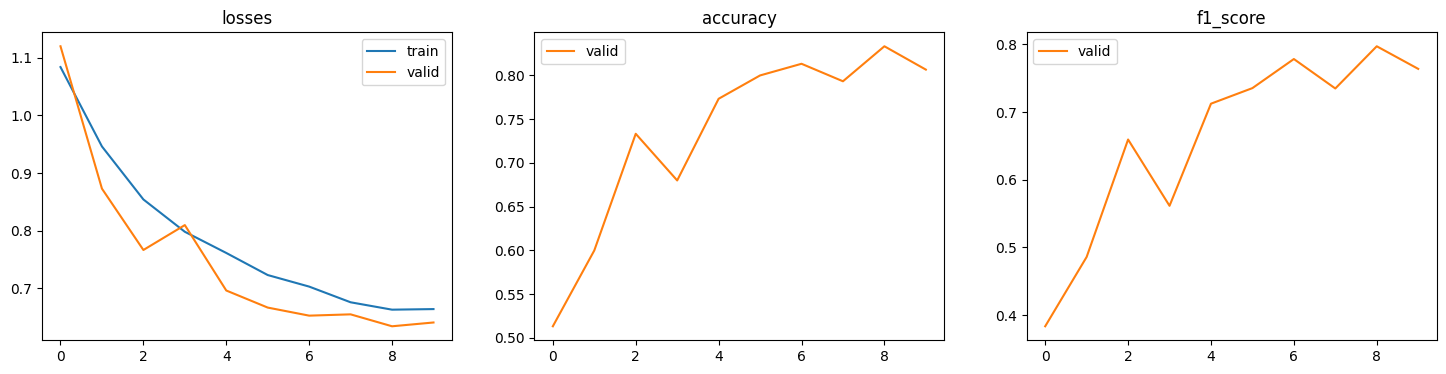

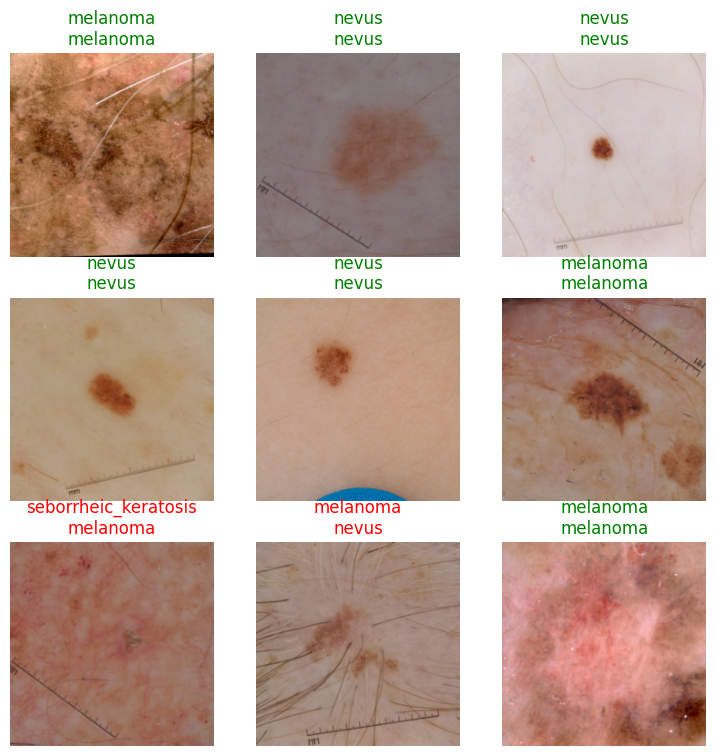

In [ ]:
# Define the number of epochs for training
epochs=10
# Find the optimal learning rate using fastai's learning rate finder
lr=learn.lr_find(suggest_funcs=(minimum, valley))

# Record the start time of training
start=time.time()
# Train the model using the one-cycle learning policy
learn.fit_one_cycle(n_epoch=epochs, lr_max=lr.valley, wd=0.2, cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))
# Record the end time of training
end = time.time()

# Print the total training time
print(f"Total training time: {end - start:.2f} seconds")
# Plot the training and validation metrics over epochs
learn.recorder.plot_metrics()
# Show results (implicitly calls show_results with default 'Validation' mode if not specified, or a quick visual check)
learn.show_results()


==================== Evaluating: Train ====================


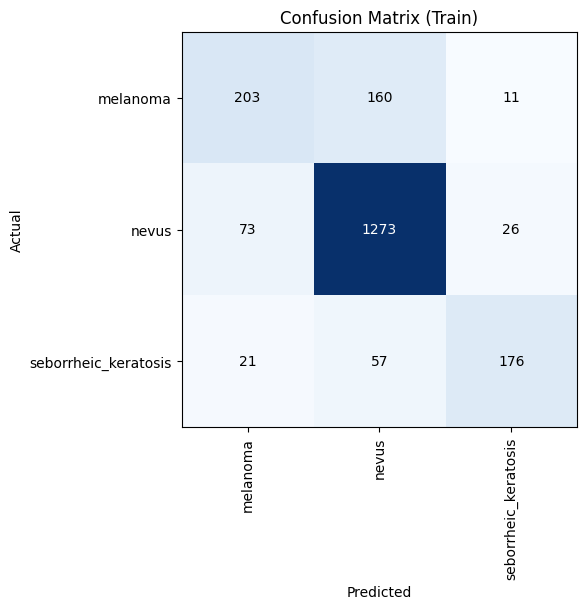

✅ Global Accuracy: 83.40%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8861
   • Recall:  0.5722


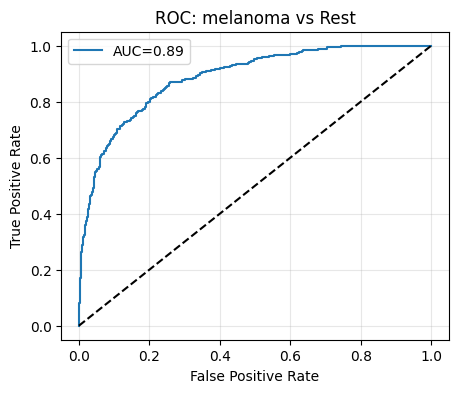

In [ ]:
show_results(dls, learn, 'Train', melanoma_class='melanoma')

## **Validation**


==================== Evaluating: Validation ====================


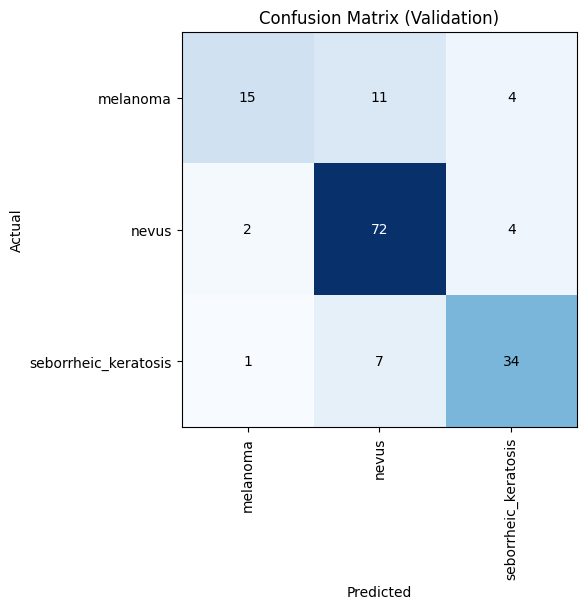

✅ Global Accuracy: 80.67%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8703
   • Recall:  0.5000


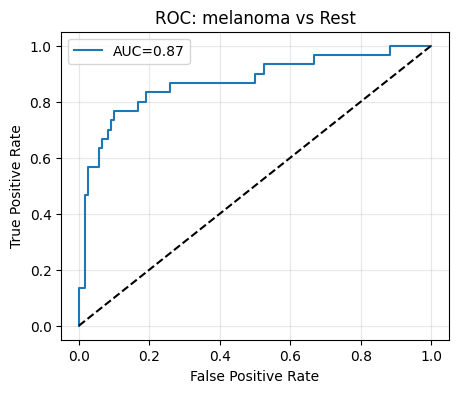

In [ ]:
show_results(dls, learn, 'Validation', melanoma_class='melanoma')

## **Test**


==================== Evaluating: Test ====================


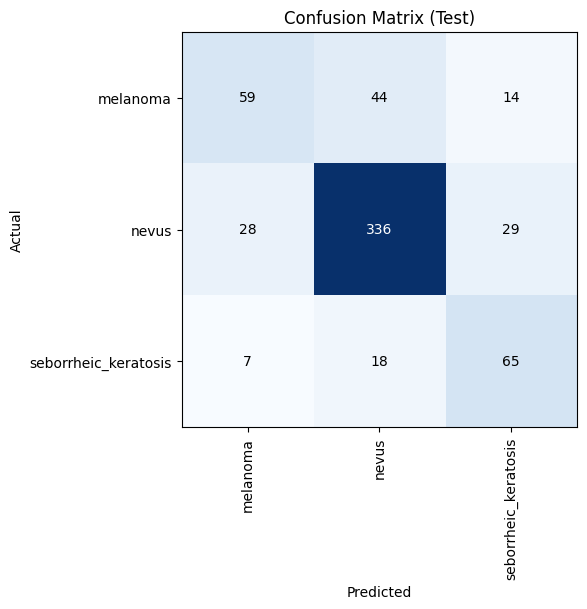

✅ Global Accuracy: 76.67%



📊 Metrics for 'melanoma':
   • ROC-AUC: 0.8268
   • Recall:  0.5043


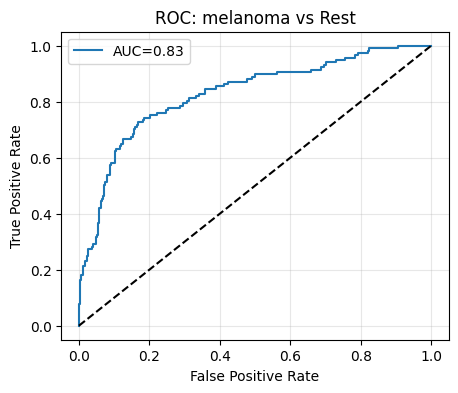

In [ ]:
show_results(dls, learn, 'Test', melanoma_class='melanoma')

## **Saving the model**

In [ ]:
drive.mount('/content/drive', force_remount=True)

# Use dill as the pickle module to avoid 'cannot pickle code objects' error
learn.export('/content/drive/My Drive/Colab Notebooks/VC/PROYECTO FINAL/vit_supervised.pkl', pickle_module=dill)

print("Model saved successfully.")

Mounted at /content/drive
Model saved successfully.


## **Conclusion**

The model performs quite well and seems to have high predictive power. Training and validation curves are well balanced and metrics are quite stable. In addition, ROC curves and coefficients illustrate good behavior en every case.

---